In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 통합데이터 read

In [7]:
df = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\naver_news_data.csv')
df

,date,time,title,content,press,link
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...
3,2017-01-01,NaN,[2017 신년특집] 세계 금융의 대변화-화폐없는 시대가 온다 디지털 가상화폐 ...,NaN,울산매일신문,http://www.iusm.co.kr
4,2017-01-01,NaN,"[아시아 밀레니얼이 미래다] 게으른 나르시스트, 신 경제 창조하는 이 시대의...",NaN,아시아투데이,http://www.asiatoday.co.kr
...,...,...,...,...,...,...
869329,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,\n스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에...,6면 1단,https://n.news.naver.com/mnews/article/277/000...
869330,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",\n'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...
869331,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,\n[the300]\n\n\n\n(서울=뉴스1) 임세영 기자 = 김남국 무소속 의원...,머니투데이,https://n.news.naver.com/mnews/article/008/000...
869332,2023-08-30,2023-08-30 06:20:57,국회 윤리특위 오늘 김남국 징계 수위 결정,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n[뉴스투데이]국회 윤리특별위원...,MBC언론사 선정,https://n.news.naver.com/mnews/article/214/000...


In [8]:
# 'content' 열이 비어있지 않은 행만 필터링
non_empty_content_datewise = df[df['content'].notnull()]


In [9]:
filtered_df = non_empty_content_datewise[
    ~non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]
removed_df = non_empty_content_datewise[
    non_empty_content_datewise['content'].str.contains('라이온봇|화폐에 대한 모든 것!', na=False)
]

print(len(non_empty_content_datewise))
print(len(filtered_df))
print(len(removed_df))

313042
255908
57134


### 날짜 처리 : UTC 기준으로 변환

In [10]:
def convert_korean_datetime_to_standard(datetime_str):
    # "오후"와 "오전"을 확인
    if "오후" in datetime_str:
        hour_offset = 12
        datetime_str = datetime_str.replace("오후", "").strip()
    elif "오전" in datetime_str:
        hour_offset = 0
        datetime_str = datetime_str.replace("오전", "").strip()
    else:
        hour_offset = 0

    # 시간과 분을 분리 (마지막 두 부분을 시간으로 간주)
    parts = datetime_str.split(' ')
    date_part = ' '.join(parts[:-1])
    time_part = parts[-1]
    
    hour, minute = map(int, time_part.split(':'))

    # "오후"의 경우 시간에 12를 더함 (단, 12시는 제외)
    if hour_offset == 12 and hour != 12:
        hour += hour_offset
    elif hour_offset == 0 and hour == 12:  # "오전"의 경우 12시는 00시로 변환
        hour = 0

    # 날짜 포맷 변환
    date_part = date_part.replace(".", "-").strip()

    # 최종 포맷 반환
    return f"{date_part} {hour:02d}:{minute:02d}:00"

# 예제
example_str = "2017.01.08. 오후 10:39"
converted_str = convert_korean_datetime_to_standard(example_str)
converted_str


'2017-01-08- 22:39:00'

In [11]:
# 'time' 열의 모든 값을 변환
filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)

# 'time' 열을 datetime 객체로 변환
filtered_df['time'] = pd.to_datetime(filtered_df['time'])

# 'time'에서 9시간을 빼서 'UTC-time' 열 생성
filtered_df['UTC-time'] = filtered_df['time'] - pd.Timedelta(hours=9)

# 'UTC-time'에서 날짜만 추출하여 'UTC-date' 열 생성
filtered_df['UTC-date'] = filtered_df['UTC-time'].dt.date

filtered_df[['time', 'UTC-time', 'UTC-date']].head()


<ipython-input-11-ed571adea1e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = filtered_df['time'].apply(lambda x: convert_korean_datetime_to_standard(x) if "." in x else x)
<ipython-input-11-ed571adea1e4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = pd.to_datetime(filtered_df['time'])
<ipython-input-11-ed571adea1e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,time,UTC-time,UTC-date
0,2017-01-01 07:00:00,2016-12-31 22:00:00,2016-12-31
1,2017-01-01 15:15:04,2017-01-01 06:15:04,2017-01-01
2,2017-01-01 16:03:04,2017-01-01 07:03:04,2017-01-01
5,2017-01-01 12:03:13,2017-01-01 03:03:13,2017-01-01
6,2017-01-01 10:33:04,2017-01-01 01:33:04,2017-01-01


In [12]:
filtered_df

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
2,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
5,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
6,2017-01-01,2017-01-01 10:33:04,5대 키워드로 보는 2016년 핀테크 트렌드,\n\t\t\t2016년 한 해 동안 다양한 핀테크 얘기가 쏟아졌다. IT 기업부터...,블로터,https://n.news.naver.com/mnews/article/293/000...,2017-01-01 01:33:04,2017-01-01
...,...,...,...,...,...,...,...,...
869327,2023-08-30,2023-08-30 06:43:01,"美법원, SEC에 비트코인 현물ETF 반려 결정 재고하라고 지시…비트코인 가격 ...",\n\n\n\n\n[로이터][헤럴드경제=김우영 기자] 미 연방법원이 비트코인 현물 ...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2023-08-29 21:43:01,2023-08-29
869329,2023-08-30,2023-08-30 06:30:00,갈수록 줄어드는 스테이블코인 유통량…가상자산 가격도 횡보,\n스테이블코인 유통량 증가하면 가상자산 가격도 올라이변 없었던 잭슨홀 미팅 호재에...,6면 1단,https://n.news.naver.com/mnews/article/277/000...,2023-08-29 21:30:00,2023-08-29
869330,2023-08-30,2023-08-30 06:54:01,"[이충재의 인사이트] 김남국 징계 계기, 국회의원 '정직 6개월' 두자",\n'30일내 출석정지'와 '제명' 간 차이 커 실효성 논란...윤리특위 징계 유명...,오마이뉴스언론사 선정,https://n.news.naver.com/mnews/article/047/000...,2023-08-29 21:54:01,2023-08-29
869331,2023-08-30,2023-08-30 06:11:00,오늘 김남국 제명안 표결···'숙고의 시간' 거친 민주당 선택은,\n[the300]\n\n\n\n(서울=뉴스1) 임세영 기자 = 김남국 무소속 의원...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,2023-08-29 21:11:00,2023-08-29


In [13]:
column_data_type = filtered_df['UTC-date'].dtype
print(f"The data type of the 'UTC-date' column is: {column_data_type}")


The data type of the 'UTC-date' column is: object


In [14]:
# Convert the column to string and strip whitespaces
filtered_df['UTC-date'] = filtered_df['UTC-date'].astype(str).str.strip()

# Filter rows with the specified date
filtered_rows = filtered_df[filtered_df['UTC-date'] == '2022-01-19']

filtered_rows

<ipython-input-14-215d8df4311f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC-date'] = filtered_df['UTC-date'].astype(str).str.strip()


,date,time,title,content,press,link,UTC-time,UTC-date
645146,2022-01-19,2022-01-19 09:23:01,"[코인뉴스] 비트코인, 바닥 친 거래량 6조원도 위태…‘춥다 추워’",\n얼어붙은 시장 분위기에 추가 시세하락 우려\n\n\n\n비트코인 관련 이미지.ⓒ...,데일리안언론사 선정,https://n.news.naver.com/mnews/article/119/000...,2022-01-19 00:23:01,2022-01-19
645149,2022-01-19,2022-01-19 09:04:00,[코인시황]비트코인 5100만원대…미 연준 긴축정책 공포,\n\n\n\n\n[서울=뉴시스]이주혜 기자 = 비트코인이 5100만원대에 머물고 ...,뉴시스,https://n.news.naver.com/mnews/article/003/001...,2022-01-19 00:04:00,2022-01-19
645151,2022-01-19,2022-01-19 09:15:25,"美 증시, 5중고에 `검은 화요일` 마진콜+단기금리 급등+B/S 축소+금융규제+실...",\n\t\t\t본격적인 어닝 시즌을 맞아 미 증시가 상승할 것이라 기대했던 서학 개...,한국경제TV,https://n.news.naver.com/mnews/article/215/000...,2022-01-19 00:15:25,2022-01-19
645152,2022-01-19,2022-01-19 12:56:35,"李 ""가상자산 법제화"" vs 尹 ""5천만원 비과세""…불붙은 코인 전쟁","\n이재명·윤석열, 19일 나란히 암호화폐 공약 발표하며 표심잡기두 후보 모두 가상...",뉴스1언론사 선정,https://n.news.naver.com/mnews/article/421/000...,2022-01-19 03:56:35,2022-01-19
645154,2022-01-19,2022-01-19 13:04:01,우리 집 공유기가 악성코드 유포? 국정원 “IoT 기기 위협에 노출”,"\n\n\n\n\n[디지털데일리 이종현기자] 글로벌 인터넷 공유기, 폐쇄회로(CC)...",디지털데일리,https://n.news.naver.com/mnews/article/138/000...,2022-01-19 04:04:01,2022-01-19
...,...,...,...,...,...,...,...,...
646970,2022-01-20,2022-01-20 00:01:37,"윤석열, 연말정산·반려동물 등 생활공약 발표",\r\n\t\t\t국민의힘 윤석열 대선 후보는 3가지 생활 밀착형 공약을 잇따라 선...,YTN,https://n.news.naver.com/mnews/article/052/000...,2022-01-19 15:01:37,2022-01-19
646972,2022-01-20,2022-01-20 03:01:06,이재명 “60세부터 年120만원 장년수당… 임플란트 건보 확대”,\r\n지지율 약세 노년층 겨냥 공약 등 발표\r\n\r\n\r\n\r\n전국 경로...,A4면 TOP,https://n.news.naver.com/mnews/article/020/000...,2022-01-19 18:01:06,2022-01-19
646974,2022-01-20,2022-01-20 05:00:00,"윤석열, 가상자산 컨퍼런스 참석…연말정산·반려동물 공약 발표",\r\n\t\t\t[[the300]]\r\n\r\n\r\n\r\n[서울=뉴시스] 전...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,2022-01-19 20:00:00,2022-01-19
646975,2022-01-20,2022-01-20 05:09:03,독주하는 ‘업비트’ 탄탄… 추격하는 ‘빗코코’ 동맹,\r\n4대 암호화폐거래소 ‘파이’ 키우기 합종연횡 진검승부업비트 시장 장악력 압도...,21면 TOP,https://n.news.naver.com/mnews/article/081/000...,2022-01-19 20:09:03,2022-01-19


In [36]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_sample = filtered_df.groupby('UTC-date').size()

# Filter dates where the count is exactly 10
# dates_with_exact_10 = datewise_counts_sample[(datewise_counts_sample >= 400) & (datewise_counts_sample <= 420)].index
dates_with_exact_10 = datewise_counts_sample.idxmax()

dates_with_exact_10

'2022-01-19'

In [9]:
def preprocess_and_vectorize(data):
    # 형태소 분석기 초기화
    okt = Okt()

    # 기사의 내용을 형태소로 분석
    tokenized_content = data['content'].apply(lambda x: ' '.join(okt.morphs(x)))

    # TF-IDF 변환
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_content)
    
    return tfidf_matrix

In [11]:
def get_representative_indices(cosine_sim, threshold=0.6):
    visited = np.zeros(cosine_sim.shape[0], dtype=bool)
    representatives = []
    
    for i in range(cosine_sim.shape[0]):
        if not visited[i]:
            similar_articles = np.where(cosine_sim[i] > threshold)[0]
            if len(similar_articles) > 0:  # Check if there are any similar articles
                representatives.append(similar_articles[0])
                visited[similar_articles] = True
            
    return representatives

def filter_articles_within_group(group_df):
    # 데이터 전처리 및 벡터화
    tfidf_matrix = preprocess_and_vectorize(group_df)

    # 코사인 유사도 계산
    cosine_sim = cosine_similarity(tfidf_matrix)

    # 대표 기사 인덱스 추출
    representative_indices = get_representative_indices(cosine_sim)
    if len(representative_indices) == 0:  # Check if there are any representative articles
        return pd.DataFrame()  # Return an empty dataframe

    # 대표 기사만 포함된 데이터프레임 반환
    return group_df.iloc[representative_indices].reset_index(drop=True)

# 'UTC-date'를 기준으로 그룹화하고 각 그룹별로 중복 기사 필터링
filtered_groups = filtered_df.groupby('UTC-date').apply(filter_articles_within_group)

# 인덱스 재설정
filtered_df_final = filtered_groups.reset_index(drop=True)

In [12]:
filtered_df_final

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30


In [13]:
print(len(filtered_df))
print(len(filtered_df_final))

259994
161567


In [17]:
filtered_df_final.to_csv('sim_del_naver_news_data.csv', encoding='utf-8-sig', index=False)

In [14]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_non_empty = filtered_df_final.groupby('UTC-date').size()

datewise_counts_non_empty

UTC-date
2016-12-31     2
2017-01-01     5
2017-01-02    18
2017-01-03    24
2017-01-04    10
              ..
2023-08-26    10
2023-08-27    33
2023-08-28    51
2023-08-29    61
2023-08-30    15
Length: 2431, dtype: int64

count    2431.000000
mean       66.461127
std        61.295285
min         1.000000
25%        24.500000
50%        49.000000
75%        91.000000
max       464.000000
dtype: float64


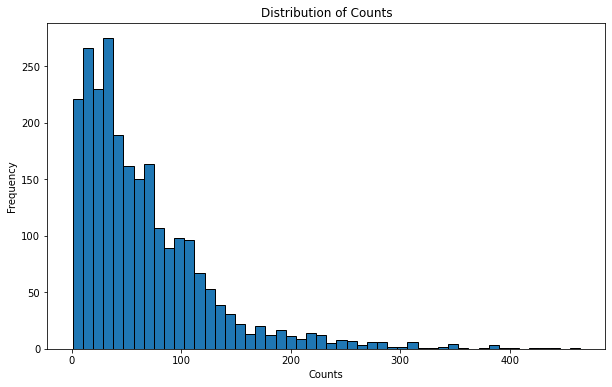

In [16]:
# 기본 통계 요약
print(datewise_counts_non_empty.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts_non_empty.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [26]:
data = filtered_df_final
data

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30


In [15]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load data
data = pd.read_csv('test.csv')

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
model.eval()

# Embed each article content using BERT
embeddings = []
for content in data['content'].tolist():
    tokens = tokenizer(content, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
    with torch.no_grad():
        out = model(**tokens)
    embeddings.append(out['pooler_output'].squeeze().numpy())

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Cluster articles based on similarity
clusters = []
visited = np.zeros(len(data), dtype=bool)
for i in range(len(data)):
    if not visited[i]:
        similar_articles = np.where(similarity_matrix[i] > 0.6)[0]
        clusters.append(similar_articles)
        visited[similar_articles] = True

# Get representative articles from each cluster
representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]

# Create a dataframe with only representative articles
filtered_data = data.iloc[representative_indices].reset_index(drop=True)
filtered_data


c:\Users\user\anaconda3\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


,date,time,title,content,press,link,year
0,2018-06-10,2018-06-10 20:32:13,"벤처스퀘어 ""블록체인과 스타트업 주제 컨퍼런스 14일 개최""",\r\n\t\t\t서울창업허브에서 10회 'GSC' 행사...비트코인 전도사 로저버...,지디넷코리아,https://n.news.naver.com/mnews/article/092/000...,2018
